In [21]:
df = catalog.load('train')

2022-07-11 03:41:16,921 - kedro.io.data_catalog - INFO - Loading data from `train` (CSVDataSet)...


# 0.0. Imports

In [22]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection as ms
from sklearn import feature_selection as fs
from sklearn import linear_model as lm
from sklearn import metrics as me
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn import metrics
import sklearn.ensemble as en

## 0.1. Helper Functions

In [23]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    pd.options.mode.chained_assignment = None 
    
    sns.set()

# Plot categorical attributes with annot
def plot_cat(att, annot=True):
    
    splot = sns.countplot(x = att)
    total = 0
    if annot == True:
        for p in splot.patches:
            total += p.get_height()
            
        for p in splot.patches:
            splot.annotate(format(p.get_height()/total, '.4f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', xytext = (0, 10), 
                           textcoords = 'offset points')

In [24]:
jupyter_settings()

## 0.2. Data

In [25]:
# Import Train Data
df_train = catalog.load('train')

# Import Test Data
df_test = catalog.load('test')

2022-07-11 03:41:18,203 - kedro.io.data_catalog - INFO - Loading data from `train` (CSVDataSet)...
2022-07-11 03:41:18,208 - kedro.io.data_catalog - INFO - Loading data from `test` (CSVDataSet)...


# 1.0. Data Description

In [26]:
df1 = df_train.copy()

## 1.1. Data Dimension

In [27]:
# number of rows
print(f'Number of rows: {df1.shape[0]}')

# number of columns
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 891
Number of columns: 12


## 1.2. Data Dtypes

In [28]:
df1.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## 1.3. Check NA

In [29]:
# check na values
df1.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## 1.5. Descriptive Statistics 

In [30]:
# df with only numerical attributes
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

# df with only categorical attributes
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

### 1.5.1. Numerical Attributes

In [31]:
# Central Tendency
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate
ct = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,PassengerId,1.00,891.0000,890.0000,446.000000,446.0000,257.209383,0.000000,-1.200000
1,Survived,0.00,1.0000,1.0000,0.383838,0.0000,0.486319,0.478523,-1.775005
2,Pclass,1.00,3.0000,2.0000,2.308642,3.0000,0.835602,-0.630548,-1.280015
3,Age,0.42,80.0000,79.5800,29.699118,NaN,14.516321,0.389108,0.178274
4,SibSp,0.00,8.0000,8.0000,0.523008,0.0000,1.102124,3.695352,17.880420
5,Parch,0.00,6.0000,6.0000,0.381594,0.0000,0.805605,2.749117,9.778125
6,Fare,0.00,512.3292,512.3292,32.204208,14.4542,49.665534,4.787317,33.398141


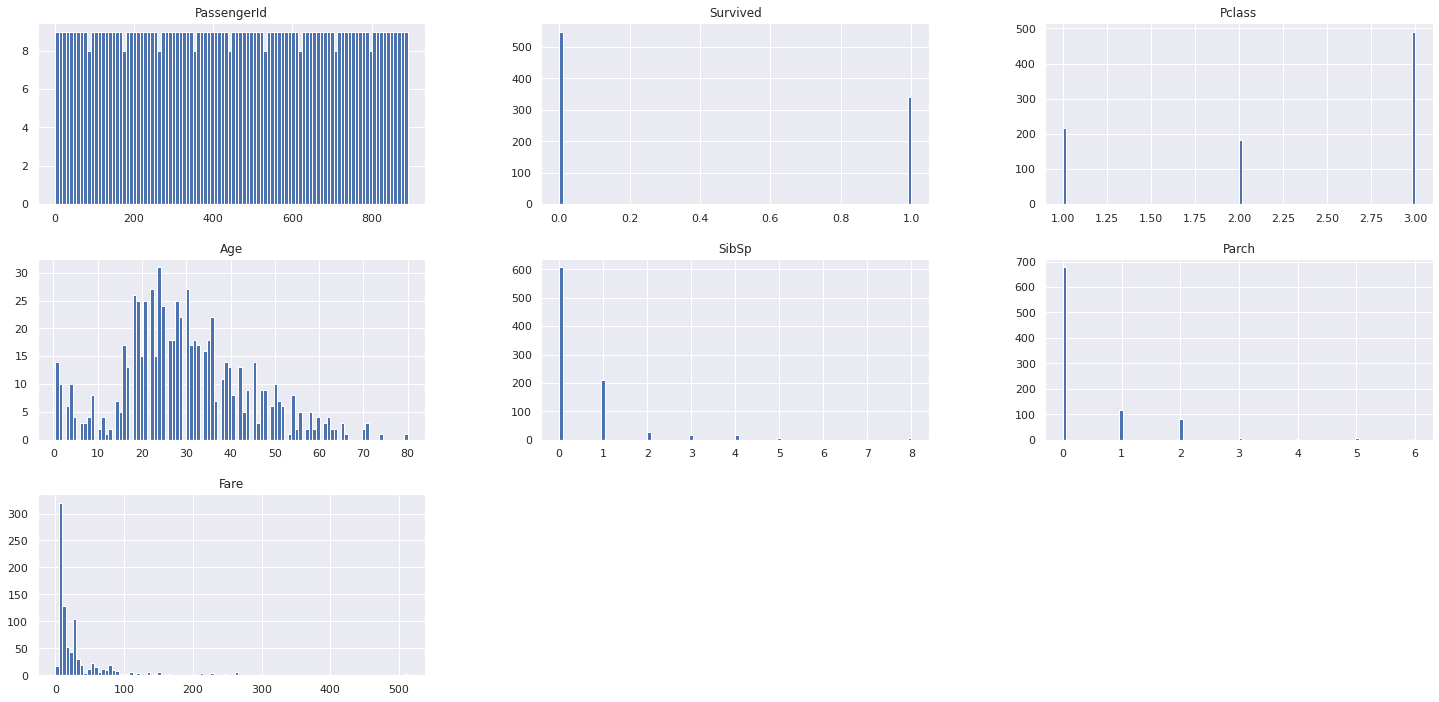

In [32]:
# plot histograms
num_attributes.hist(bins=100);

### 1.5.2. Categorical Variables

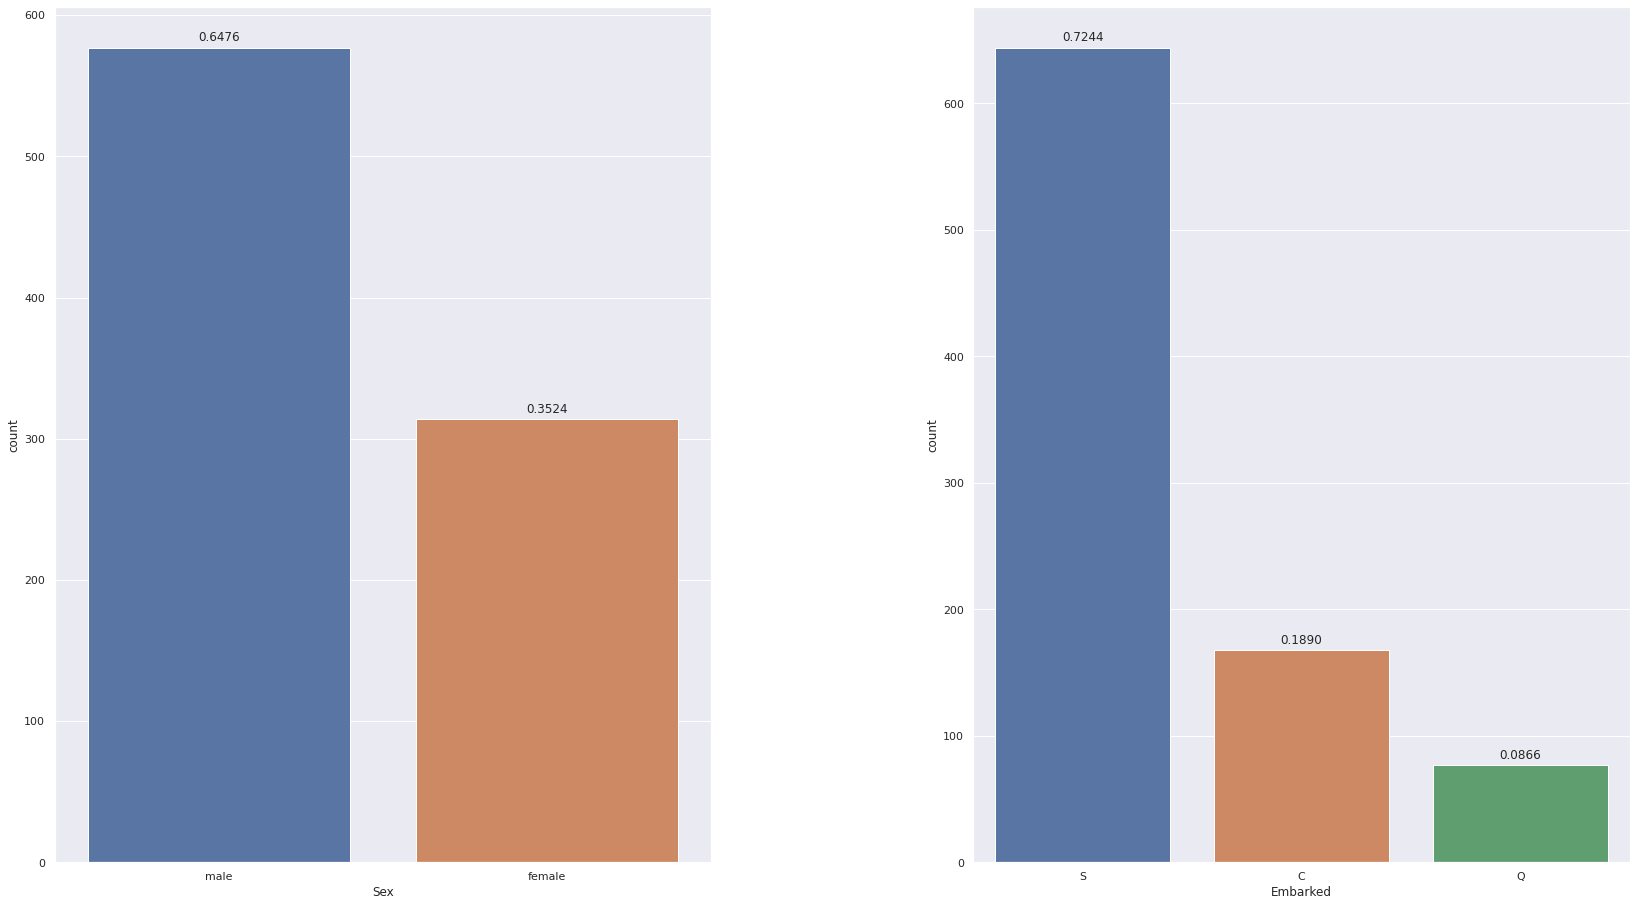

In [33]:
# create grid
grid = plt.GridSpec(1, 2)

# print countplot Sex
plt.subplot(grid[0, 0])
plot_cat(cat_attributes['Sex'])

# print countplot Embarked
plt.subplot(grid[0, 1])
plot_cat(cat_attributes['Embarked'])

plt.subplots_adjust(left=0.125,
                    bottom=0.01, 
                    right=1, 
                    top=1, 
                    wspace=0.4, 
                    hspace=0.40)

# 2.0. Feature Engineering

In [34]:
df2 = df1.copy()

## 2.1. Cabin

In [35]:
df2['Region_Cabin'] = df2['Cabin'].apply(lambda x: str(x)[0] if x is not np.nan else 'empty')

## 2.2. Title

In [36]:
df2['Title'] = df2['Name'].apply(lambda x: str(x).split(',')[1].split('.')[0])

In [37]:
df2

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Region_Cabin,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,empty,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,empty,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,empty,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,empty,Rev
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,B,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,empty,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,C,Mr


# 3.0. Exploratory Data Analysis

In [38]:
df3 = df2.copy()

## 3.1. Univariate Analysis

In [39]:
df3

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Region_Cabin,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,empty,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,empty,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,empty,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,empty,Rev
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,B,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,empty,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,C,Mr


## 3.2. Bivariate Analysis

## 3.3. Multivariate Analysis

# 4.0. Data Preparation

In [40]:
df4 = df3.copy()

## 4.1. Filter 

In [41]:
df4

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Region_Cabin,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,empty,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,empty,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,empty,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,empty,Rev
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,B,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,empty,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,C,Mr


In [42]:
df4 = df4[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Region_Cabin', 'Title', 'Survived']]

## 4.2. Encoding

In [43]:
df4 = pd.get_dummies(df4, 's_', columns=['Sex'], drop_first=True)
df4 = pd.get_dummies(df4, 't_', columns=['Title'], drop_first=True)
df4 = pd.get_dummies(df4, 'r_', columns=['Region_Cabin'], drop_first=True)
df4 = pd.get_dummies(df4, 'e_', columns=['Embarked'], drop_first=True)

## 4.3. Train Test Split

In [44]:
# Separating response variable
X = df4.drop('Survived', axis=1)
y = df4.loc[:, 'Survived']

In [45]:
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32, stratify=y)

# 5.0. Feature Selection

In [46]:
def train_pipeline(X_train, y_train, model):
    imp = SimpleImputer(missing_values=np.nan, strategy='median')
    
    pipeline = Pipeline([
        ('imp', imp),
        ('clf', model)
    ])
    
    pipeline.fit(X_train, y_train)
    
    return pipeline

In [47]:
rf_model = en.RandomForestClassifier(n_jobs=-1)
model = train_pipeline(X_train, y_train, rf_model)

<AxesSubplot:>

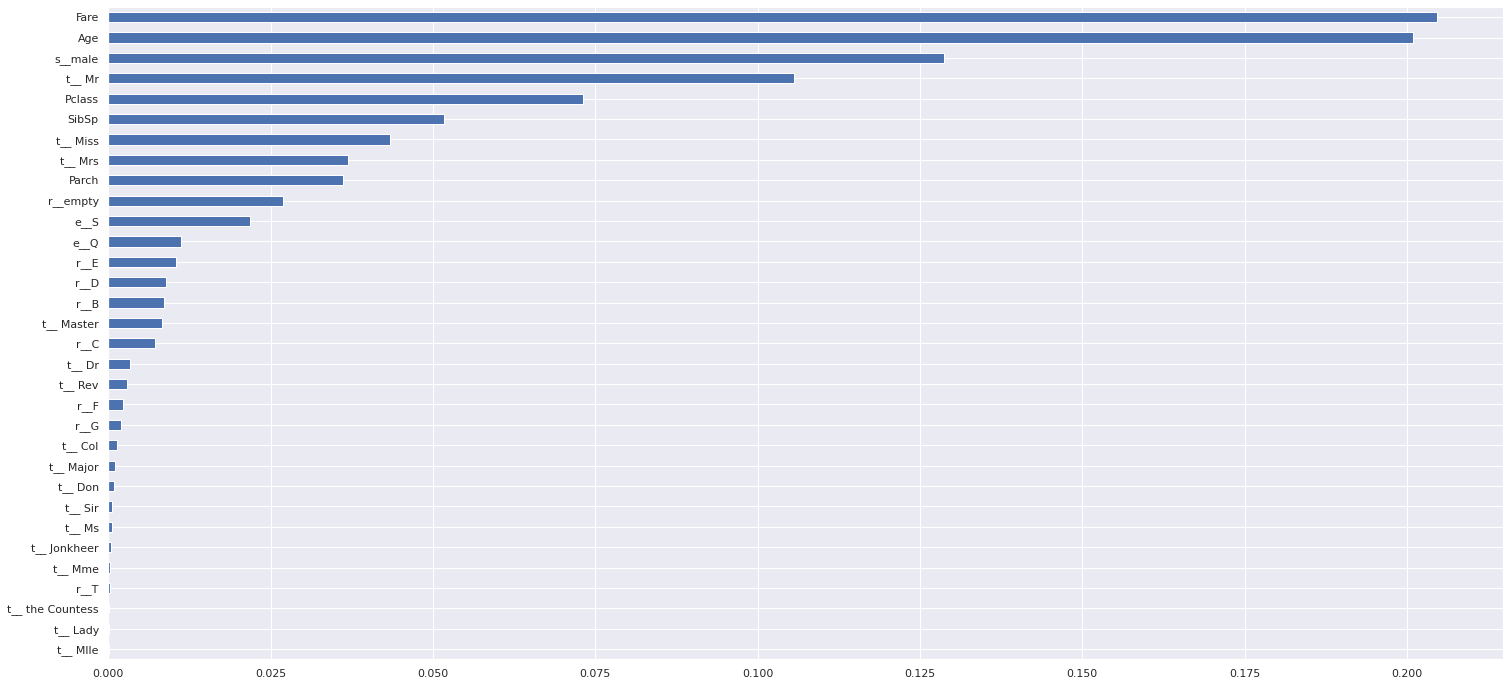

In [48]:
# feature importances
feat_importances = pd.Series(model.steps[1][1].feature_importances_, index=X_train.columns)

# plot feature importances
feat_importances.sort_values().plot(kind='barh')

In [49]:
rfe_model = fs.RFE(estimator=model.steps[1][1], n_features_to_select=5)
model = train_pipeline(X_train, y_train, rfe_model)

In [50]:
# show values
for i in range(X_train.shape[1]):
    print('{} - Rank: {}'.format(X_train.columns[i], model.steps[1][1].ranking_[i]))

Pclass - Rank: 1
Age - Rank: 1
SibSp - Rank: 2
Parch - Rank: 3
Fare - Rank: 1
s__male - Rank: 1
t__ Col - Rank: 19
t__ Don - Rank: 20
t__ Dr - Rank: 15
t__ Jonkheer - Rank: 21
t__ Lady - Rank: 25
t__ Major - Rank: 18
t__ Master - Rank: 12
t__ Miss - Rank: 5
t__ Mlle - Rank: 26
t__ Mme - Rank: 27
t__ Mr - Rank: 1
t__ Mrs - Rank: 4
t__ Ms - Rank: 23
t__ Rev - Rank: 14
t__ Sir - Rank: 22
t__ the Countess - Rank: 28
r__B - Rank: 13
r__C - Rank: 11
r__D - Rank: 10
r__E - Rank: 8
r__F - Rank: 16
r__G - Rank: 17
r__T - Rank: 24
r__empty - Rank: 6
e__Q - Rank: 9
e__S - Rank: 7


# 6.0. Model 

In [51]:
def evaluate_models(X, y, list_models, cv_iter=5, imput_strat='mean'):
    """
    Evaluates the models listed in Cross validation and returns a dataframe 
    with the average performance of each metric for each model.
    """
    imp = SimpleImputer(missing_values=np.nan, strategy=imput_strat)
    
    for count, model in enumerate(list_models):
        pipeline = Pipeline([
            ('imp', imp),
            ('clf', model)
        ])

        scoring = {'acc': 'accuracy',
                   'precision': 'precision',
                   'recall': 'recall',
                   'f1': 'f1',
                   'roc_auc': 'roc_auc'}

        scores = ms.cross_validate(pipeline, X, y, cv=cv_iter, scoring=scoring)

        if count == 0:
            df_scores = pd.DataFrame(pd.DataFrame(scores).mean()).T
            df_scores.index = index=[type(model).__name__]

        else:
            df_aux = pd.DataFrame(pd.DataFrame(scores).mean()).T
            df_aux.index = index=[type(model).__name__]
            df_scores = pd.concat([df_scores, df_aux])
            
    return df_scores

In [52]:
# list of models to show performance in train dataset
list_models = [
    lm.LogisticRegression(random_state=32),
    en.RandomForestClassifier(n_jobs=-1), 
]

In [53]:
evaluate_models(X_train, y_train, list_models)

/home/tadeucbm/indicium_proj/lighthouse/kedro_titanic/venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/tadeucbm/indicium_proj/lighthouse/kedro_titanic/venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative so

,fit_time,score_time,test_acc,test_precision,test_recall,test_f1,test_roc_auc
LogisticRegression,0.041684,0.008140,0.832778,0.790555,0.768754,0.778688,0.875625
RandomForestClassifier,0.423223,0.220739,0.821590,0.780425,0.747071,0.761995,0.863714


# 7.0. Performance

## 7.1. Baseline

In [54]:
df_test = pd.merge(X_test, y_test, left_index=True, right_index=True)

In [55]:
df_test['pred'] = 0

In [56]:
df_test

,Pclass,Age,SibSp,Parch,Fare,s__male,t__ Col,t__ Don,t__ Dr,t__ Jonkheer,...,r__D,r__E,r__F,r__G,r__T,r__empty,e__Q,e__S,Survived,pred
630,1,80.0,0,0,30.0000,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
795,2,39.0,0,0,13.0000,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
103,3,33.0,0,0,8.6542,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
813,3,6.0,4,2,31.2750,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
705,2,39.0,0,0,26.0000,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,1,50.0,1,0,55.9000,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
85,3,33.0,3,0,15.8500,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,0
138,3,16.0,0,0,9.2167,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
341,1,24.0,3,2,263.0000,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [57]:
base_prec = me.precision_score(df_test['Survived'], df_test['pred']) * 100
base_recall = me.recall_score(df_test['Survived'], df_test['pred']) * 100
base_accuracy = me.accuracy_score(df_test['Survived'], df_test['pred']) * 100

/home/tadeucbm/indicium_proj/lighthouse/kedro_titanic/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 7.2. Model

In [58]:
def final_model(model, X_train, y_train, imput_strat='median'):
    """
    Function that performs the finetuning of the model with the desired parameters
    """
    imp = SimpleImputer(missing_values=np.nan, strategy=imput_strat)
    
    pipeline = Pipeline([
        ('imp', imp),
        ('clf', model)
        ])

    train_model = pipeline.fit(X_train, y_train)
    
    return train_model

In [59]:
model = final_model(lm_model, X_train, y_train)

model_prec = me.precision_score(y_test, predicts_test) * 100
model_recall = me.recall_score(y_test, predicts_test) * 100
model_accuracy = me.accuracy_score(y_test, predicts_test) * 100

NameError: name 'lm_model' is not defined

In [ ]:
predicts_test = model.predict(X_test)

In [ ]:
df_compare = pd.DataFrame({'Baseline': [base_prec, base_recall, base_accuracy],
                           'Model': [model_prec, model_recall, model_accuracy]},
                          index=['Precision', 'Recall', 'Accuracy']).T.reset_index()
df_compare.rename({'index': 'Type'}, axis=1, inplace=True)

In [ ]:
df_compare

,Type,Precision,Recall,Accuracy
0,Baseline,0.000000,0.000000,61.452514
1,Model,76.923077,72.463768,81.005587


In [ ]:
df_compare_aux = df_compare.melt(id_vars='Type').rename(columns=str.title)

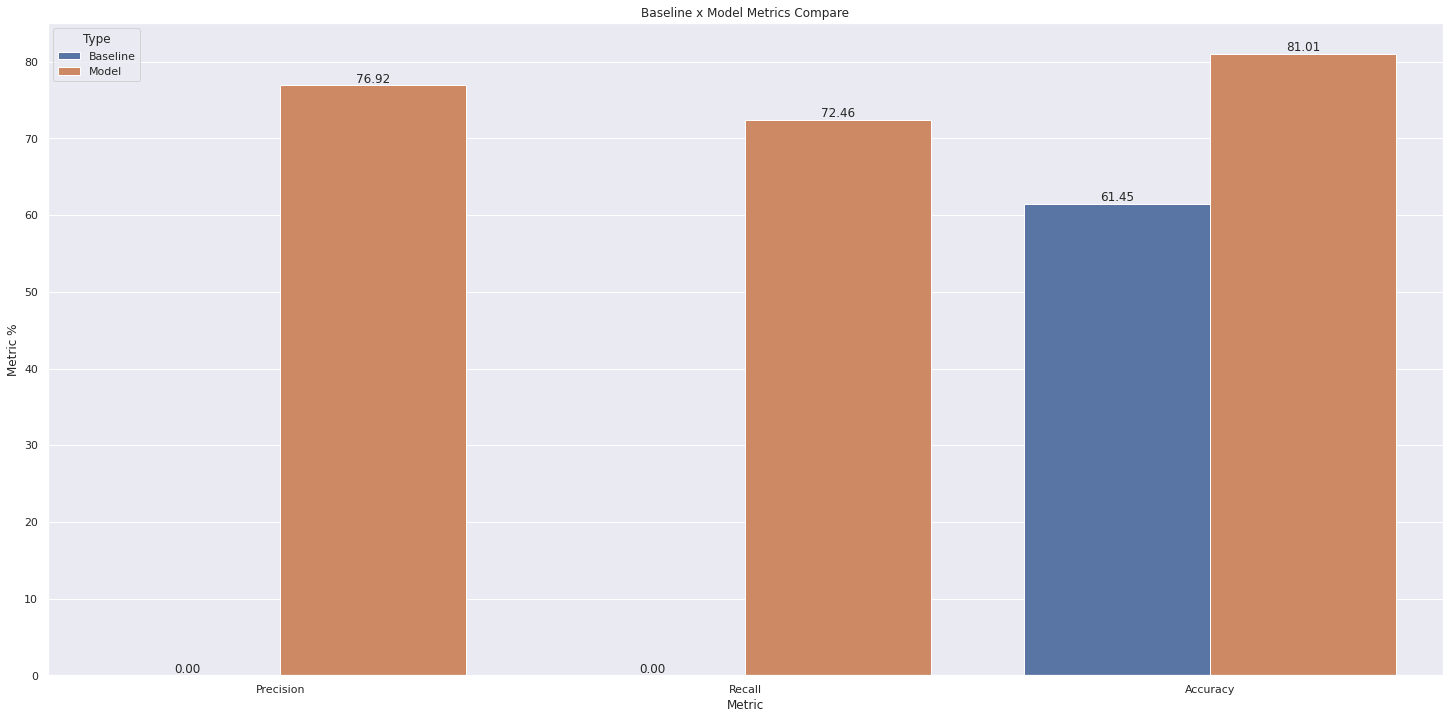

In [ ]:
fig, ax = plt.subplots()

sns.barplot(x='Variable', y='Value', hue='Type', data=df_compare_aux)

plt.title('Baseline x Model Metrics Compare')
plt.ylabel('Metric %')
plt.xlabel('Metric')

ax.bar_label(ax.containers[-2], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[-1], fmt='%.2f', label_type='edge');